# Week 1 Challenge Project
This is the complete notebook, which includes both the data cleaning and visualization section released on Day 2, and additional guidelines for model creation and evaluation. If you were already working on the notebook from before, you may have to copy your work over.

At the end of this notebook, there is also a description of how to finalize and present your project.

## 1.Challenge Introduction

> Original author: Lyle Lalunio

Hypothyroidism, also called underactive thyroid or low thyroid, is a disorder of the endocrine system in which the thyroid gland does not produce enough thyroid hormone. It can cause a number of symptoms, such as poor ability to tolerate cold, a feeling of tiredness, constipation, depression, and weight gain. Occasionally there may be swelling of the front part of the neck due to goitre. Untreated hypothyroidism during pregnancy can lead to delays in growth and intellectual development in the baby or cretinism.

Worldwide, too little iodine in the diet is the most common cause of hypothyroidism. In countries with enough iodine in the diet, the most common cause of hypothyroidism is the autoimmune condition Hashimoto's thyroiditis. Less common causes include: previous treatment with radioactive iodine, injury to the hypothalamus or the anterior pituitary gland, certain medications, a lack of a functioning thyroid at birth, or previous thyroid surgery. The diagnosis of hypothyroidism, when suspected, can be confirmed with blood tests measuring thyroid-stimulating hormone (TSH) and thyroxine levels.

Worldwide about one billion people are estimated to be iodine deficient; however, it is unknown how often this results in hypothyroidism. In the United States, hypothyroidism occurs in 0.3–0.4% of people.

And that is why we iodize salt.

![alt text](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/39/ds00181_-ds00344_-ds00353_-ds00491_-ds00492_-ds00567_-ds00660_-my00709_im01872_thyroid_gif.jpg)



Background: Doctors all around the world need our help to predict whether a patient has hypothyroid disease. We have already overspent our budget to collect such complete data on about 30 attributes for 2800 patients--a good starting number, but a larger sample would certainly be preferred. Moving forward, however, we simply cannot afford to spend so much money on data collection. Therefore, we also need to determine which attributes are the most meaningful to the predictive models, and cut out the rest that don't contribute much.

The boss wants to see a **balanced** model that can predict with a **high sensitivity** and **high specificity** while using a ***low amount of features***. Collecting complete data such as this is very rare, very time-consuming, and often very expensive. By minimizing the number of features, it will optimize future data collection by deciding what needs to be collected, and what doesn't.

## 2.Loading

We’ll use:
- `pandas` / `numpy` for data handling  
- `matplotlib` / `seaborn` for EDA  
- `scikit-learn` for modeling  

### 2.1 Libraries Import

In [ ]:
  import pandas as pd
  import numpy as np
  import seaborn as sns
  import matplotlib.pyplot as plt
  from sklearn import metrics
  from sklearn.linear_model import LogisticRegression
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score, confusion_matrix
  from sklearn.metrics import roc_curve, auc
  from sklearn import tree
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier

### 2.2 Loading the data

In [ ]:
train_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/ChallengeProjects/Week1/allhypo.train.data.csv"
test_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/ChallengeProjects/Week1/allhypo.test.data.csv"

#names = ["Age", "Sex", "On thyroxine", "query on thyroxine", "on antithyroid medication", "sick", "pregnant", "thyroid surgery", "I131 treatment", "query hypothyroid", "lithium", "goitre", "tumor", "psych", "TSH", "" "class"]
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

invalid = ["TBG", "referral source"]
train_df.drop(columns=invalid, inplace=True, errors='ignore')
test_df.drop(columns=invalid, inplace=True, errors='ignore')
train_df['class'] = train_df['class'].str.split('.').str[0]


### 2.3 Summary Stats
describe() and info() for some observations

In [ ]:
train_df.describe()

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,class
count,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,...,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800
unique,94,3,2,2,2,2,2,2,2,2,...,2,65,2,218,2,139,2,210,1,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,t,?,f,negative
freq,75,1830,2470,2760,2766,2690,2759,2761,2752,2637,...,2215,585,2616,184,2503,297,2505,295,2800,2580


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        2800 non-null   object
 1   Sex                        2800 non-null   object
 2   On thyroxine               2800 non-null   object
 3   query on thyroxine         2800 non-null   object
 4   on antithyroid medication  2800 non-null   object
 5   sick                       2800 non-null   object
 6   pregnant                   2800 non-null   object
 7   thyroid surgery            2800 non-null   object
 8   I131 treatment             2800 non-null   object
 9   query hypothyroid          2800 non-null   object
 10  query hyperthyroid         2800 non-null   object
 11  lithium                    2800 non-null   object
 12  goitre                     2800 non-null   object
 13  tumor                      2800 non-null   object
 14  psych   

## 3.Data Cleaning & Preprocessing

1. **Map all binary/categorical flags to numeric**  
   - Convert sex (`F`/`M`) and boolean flags (`f`/`t`) to `0`/`1` for scikit-learn compatibility.  
   - Collapse the various hypothyroid labels (`compensated`, `primary`, `secondary`) into a single positive class (`1`), and map `negative` to `0`.  

2. **Handle missing values**  
   - Treat every question-mark (`"?"`) as a missing entry (`NaN`) at read-in time.  
   - After type conversion, any remaining non-numeric values automatically become `NaN`.  

3. **Type conversion**  
   - Coerce all columns to numeric with `pd.to_numeric(errors='coerce')`, so stray strings are turned to `NaN`.  

4. **Median imputation**  
   - Replace each feature’s `NaN` values with its median.  

5. **Prune uninformative columns**  
   - Drop `TBG` (all missing) and `referral source` (free-text metadata).  
   - Any “measured” flags (e.g. `TSH measured`) will be dropped later if they show no predictive signal.



In [ ]:
from multiprocessing import process
def format_class_labels(df):
  new_df = df.copy()
  mapping = {
    **dict.fromkeys(["F","f"],0),
    **dict.fromkeys(["M","t"],1),
    "negative":0,
    **dict.fromkeys(["compensated hypothyroid","primary hypothyroid","secondary hypothyroid"], 1)
  }

  new_df.replace(mapping, inplace=True)
  new_df.replace("?", np.nan, inplace=True)

  for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce')
    if new_df[col].dtype in [np.float64, np.int64]:
        median = new_df[col].median()
        new_df[col].fillna(median, inplace=True)
  return new_df

processed_train_df = format_class_labels(train_df)
processed_test_df = format_class_labels(test_df)
processed_train_df.head()



/tmp/ipython-input-103-3184256679.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df.replace(mapping, inplace=True)
/tmp/ipython-input-103-3184256679.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df.replace("?", np.nan, inplace=True)
/tmp/ipython-input-103-3184256679.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,class
0,41.0,0.0,0,0,0,0,0,0,0,0,...,1,2.5,1,125.0,1,1.14,1,109.0,0,0
1,23.0,0.0,0,0,0,0,0,0,0,0,...,1,2.0,1,102.0,0,0.98,0,107.0,0,0
2,46.0,1.0,0,0,0,0,0,0,0,0,...,0,2.0,1,109.0,1,0.91,1,120.0,0,0
3,70.0,0.0,1,0,0,0,0,0,0,0,...,1,1.9,1,175.0,0,0.98,0,107.0,0,0
4,70.0,0.0,0,0,0,0,0,0,0,0,...,1,1.2,1,61.0,1,0.87,1,70.0,0,0


## 4.Data Analysis and Visualization
- Compute correlations  
- Display heatmap of features

In [ ]:
processed_train_df.corr()

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,class
Age,1.000000,-0.005742,0.004665,-0.015862,-0.069307,0.081523,-0.109117,-0.032324,0.054673,0.023957,...,0.073801,-0.219669,0.064442,-0.048018,0.086132,-0.152262,0.085041,0.038864,NaN,-0.013881
Sex,-0.005742,1.000000,-0.082493,0.043805,-0.031405,0.004839,-0.081164,-0.039495,-0.028288,-0.029970,...,0.088892,-0.063645,0.076595,-0.156434,0.048326,-0.220715,0.049443,-0.029915,NaN,-0.041927
On thyroxine,0.004665,-0.082493,1.000000,0.002667,-0.000072,-0.051109,0.010769,0.041619,0.079724,0.074691,...,-0.155443,0.021724,0.016476,0.210841,0.025192,0.051550,0.024417,0.179165,NaN,-0.086153
query on thyroxine,-0.015862,0.043805,0.002667,1.000000,-0.013347,0.022131,0.035436,0.011373,-0.015899,-0.029931,...,-0.034371,-0.020480,0.031928,-0.012448,0.031695,-0.013105,0.031510,-0.004116,NaN,-0.001598
on antithyroid medication,-0.069307,-0.031405,-0.000072,-0.013347,1.000000,-0.022420,0.067926,-0.013177,0.010479,-0.013638,...,0.008852,0.073498,-0.036398,0.002370,-0.035937,0.060408,-0.036302,-0.037223,NaN,-0.020256
sick,0.081523,0.004839,-0.051109,0.022131,-0.022420,1.000000,-0.024651,-0.024034,-0.026706,0.036088,...,0.027051,-0.079900,0.001696,-0.033908,0.015927,-0.040313,0.015504,-0.015405,NaN,0.016105
pregnant,-0.109117,-0.081164,0.010769,0.035436,0.067926,-0.024651,1.000000,-0.014488,-0.016100,-0.017610,...,0.026080,0.186062,0.032330,0.193260,0.041992,0.361852,0.041833,-0.010409,NaN,-0.035597
thyroid surgery,-0.032324,-0.039495,0.041619,0.011373,-0.013177,-0.024034,-0.014488,1.000000,-0.015696,-0.016534,...,-0.013881,-0.026888,0.031520,-0.029901,0.001354,0.020149,0.001081,-0.036250,NaN,-0.012054
I131 treatment,0.054673,-0.028288,0.079724,-0.015899,0.010479,-0.026706,-0.016100,-0.015696,1.000000,0.049420,...,0.000193,0.014453,0.035026,-0.010730,0.027623,0.009450,0.027398,-0.017831,NaN,0.012563
query hypothyroid,0.023957,-0.029970,0.074691,-0.029931,-0.013638,0.036088,-0.017610,-0.016534,0.049420,1.000000,...,-0.074829,-0.041639,0.016691,-0.012811,0.006388,0.013856,0.005829,-0.022468,NaN,0.074787


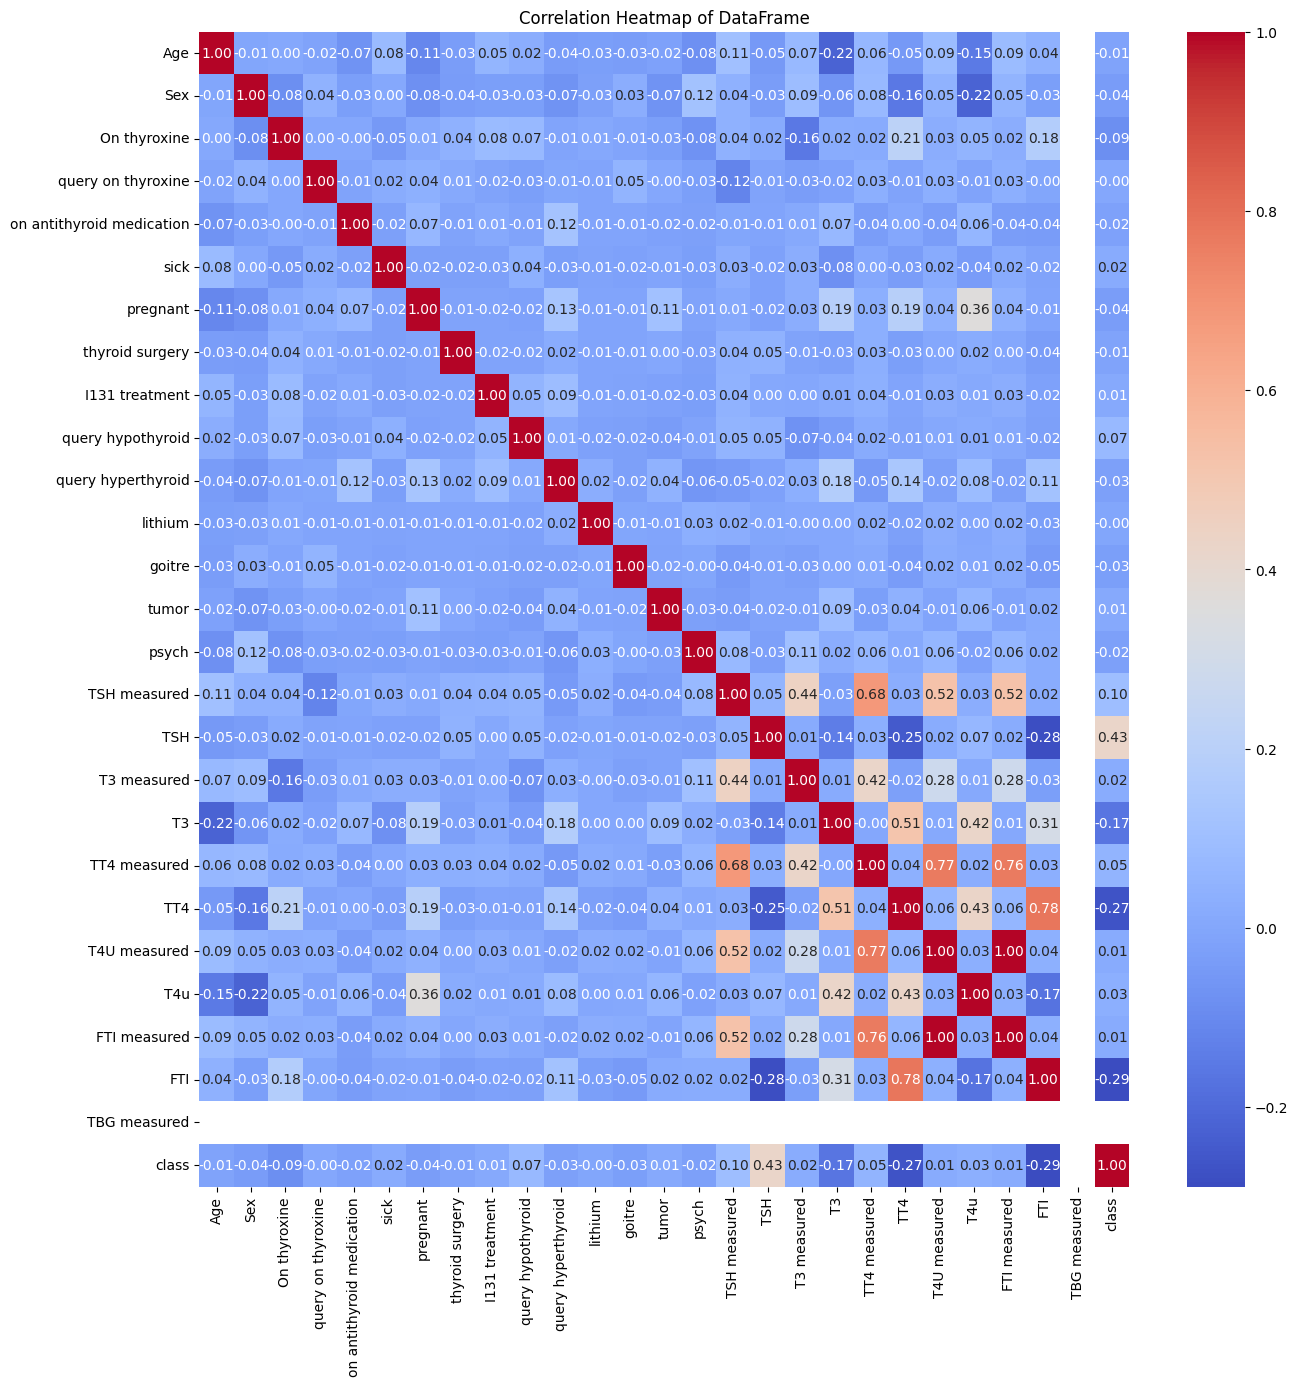

In [ ]:
  correlation_matrix = processed_train_df.corr()

  plt.figure(figsize=(15, 15)) # Adjust figure size as needed
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Heatmap of DataFrame')
  plt.show()



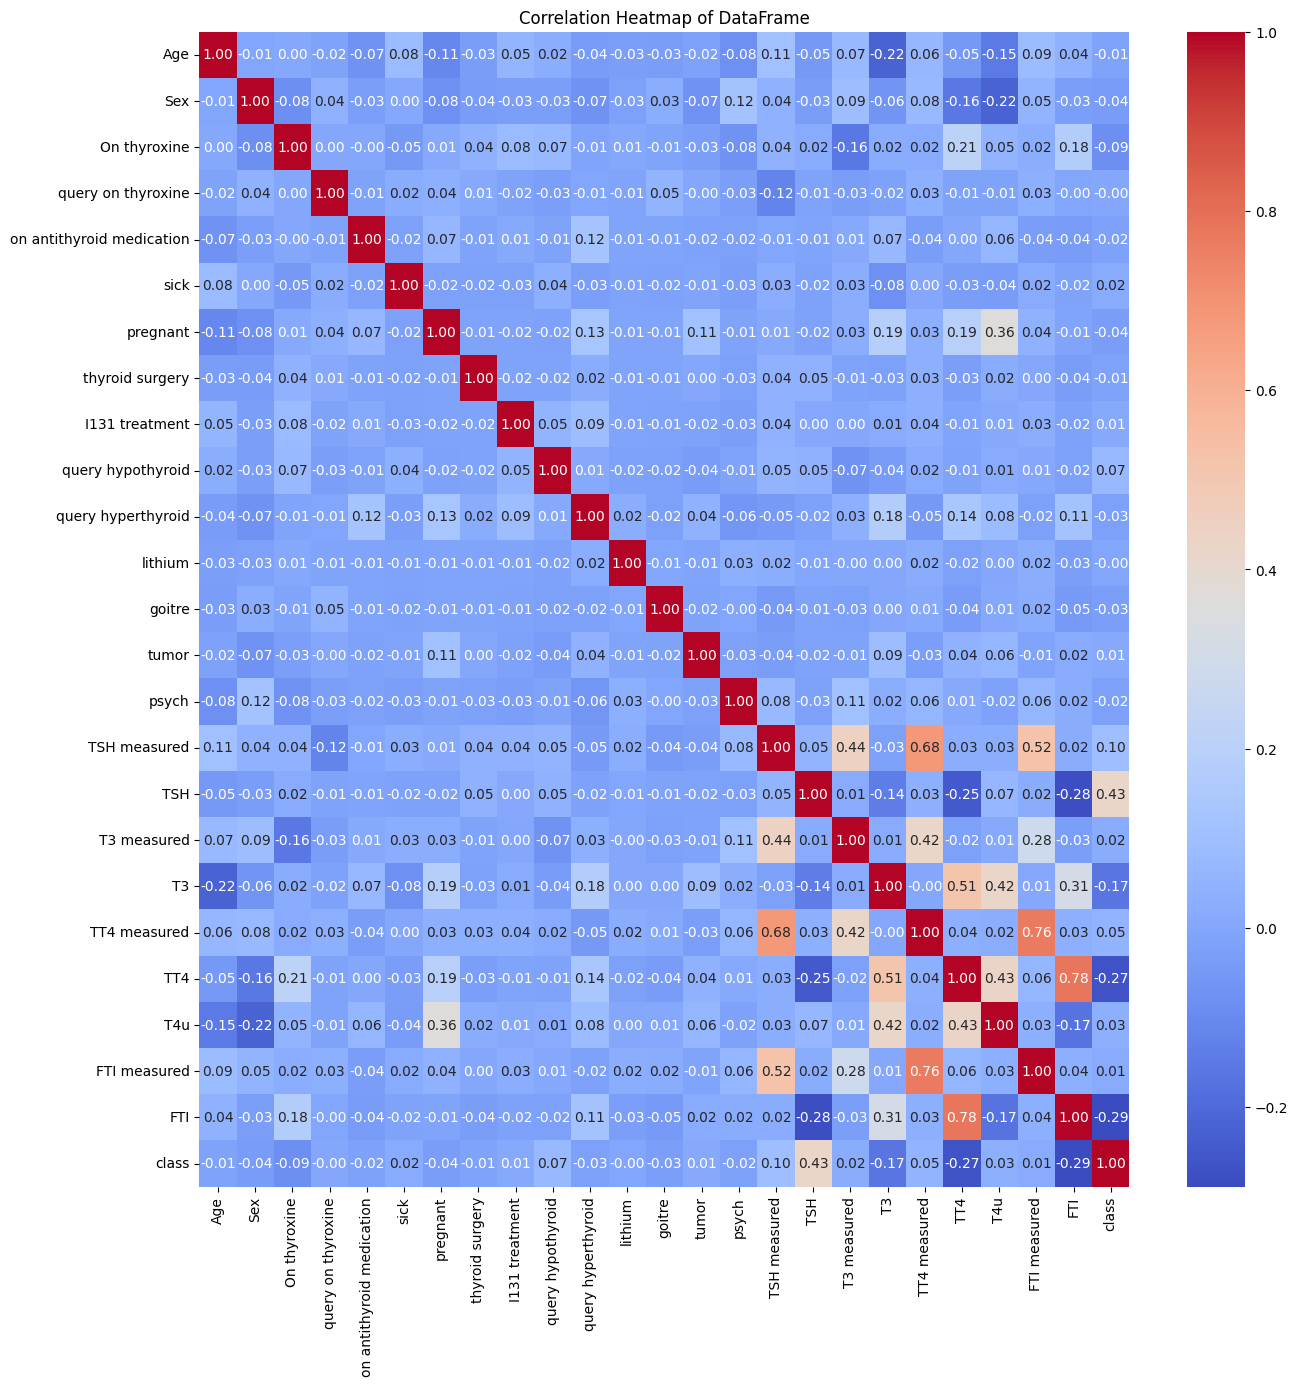

In [ ]:
invalid = ["T4U measured", "TBG measured"]
for i in processed_train_df.columns:
    if i in invalid:
      processed_train_df.drop(i, axis=1, inplace= True)
      processed_test_df.drop(i, axis=1, inplace= True)

correlation_matrix = processed_train_df.corr()

plt.figure(figsize=(15, 15)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame')
plt.show()

## 5.Model training and selection

### 5.1 Train-Test Split
Split data into 80% training and 20% testing sets

In [ ]:
y_col = "class"
X_cols = [col for col in processed_train_df.columns if col != "class"]

X_train, X_test, y_train, y_test = train_test_split(processed_train_df[X_cols], processed_train_df[y_col], test_size = 0.2, random_state=8675309)


### 5.2 Logistic Regression
For reusability, let's make a logistic regression function that will take our training and testing data as arguments. Inside the function, build a model on your training data, fit it with your training class data, and return a list of your predictions.

In [ ]:
def log_reg(train_X,train_Y,test_X,test_Y):

  model = LogisticRegression(max_iter=1000)
  model.fit(train_X, train_Y)
  y_pred = model.predict(test_X)
  return y_pred

## 6.Model evaluation

### 6.1 Zero_rule_algorithm

To start, let's establish the baseline performance. This is important because it provides a starting point of comparison for later evaluation methods, like accuracy.

A good baseline model to use is the Zero Rule algorithm. In classification problems, it simply predicts the class value with the greatest number of instances every time.

In [ ]:
def zero_rule_algorithm_classification(train,test):
  majority_class = train['class'].mode()[0]
  return np.full(shape=len(test), fill_value=majority_class)

Get your baseline performance by calculating the accuracy of your Zero Rule algorithm.

In [ ]:
y_pred = zero_rule_algorithm_classification(processed_train_df, X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9267857142857143


### 6.2 Confusion Matrix

So maybe accuracy isn't the best performance measure for this dataset. As you've seen already, even when the models predict "negative" for all the records, we could already achieve a ~92% accuracy. However, that also implies we incorrectly predicted 100% of the positive cases, which in the context of this problem, is fatal.

Thankfully, it isn't the only way to evaluate your model. Let's start by creating a confusion matrix using the logistic regression function you built earlier.

In [ ]:
y_pred = log_reg(X_train, y_train, X_test, y_test)
confusion_matrix(y_test, y_pred)


array([[515,   4],
       [ 15,  26]])

### 6.3 ROC Curve

Hopefully you remember our discussion of the Area Under the Receiver Operator Curve metric. This can measure the accuracy of a test to discriminate diseased cases from normal cases.

When you consider the results of a particular test in two populations, one population with a disease, the other population without the disease, you will rarely observe a perfect separation between the two groups. Hence, the overlapping areas in the diagram below (FN, FP).

To review, on a Receiver Operating Characteristic (ROC) curve, the true positive rate is plotted in function of the false positive rate for different cut-off points. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner. Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test.

![alt text](https://www.medcalc.org/manual/_help/images/roc_intro1.png)





Now, to graph the AUROC curve, we will need to predict probabilities of choosing a specific class value rather than the class value itself. Make a new logistic regression model that does so.

#### 6.3.1 Logistic Regression

In [ ]:
def log_reg_prob(train_X,train_Y,test_X,test_Y):

  model = LogisticRegression(max_iter=1000)
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)

  return y_pred[:,1]

Now graph the ROC curve using matplotlib, fully labeled.

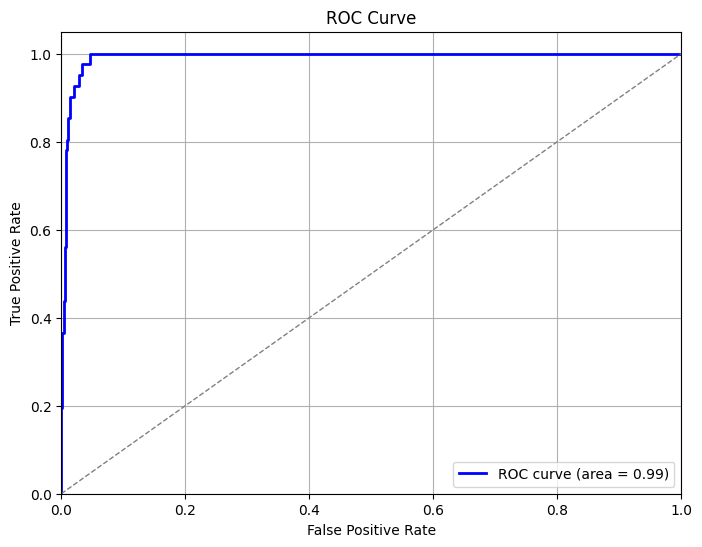

In [ ]:
y_scores = log_reg_prob(X_train, y_train, X_test, y_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In conclusion, it looks like this model performed pretty bad. It's probably best to try out different columns or perhaps use a different model before we submit our model for scoring. Get creative!

#### 6.3.2 Random Forest

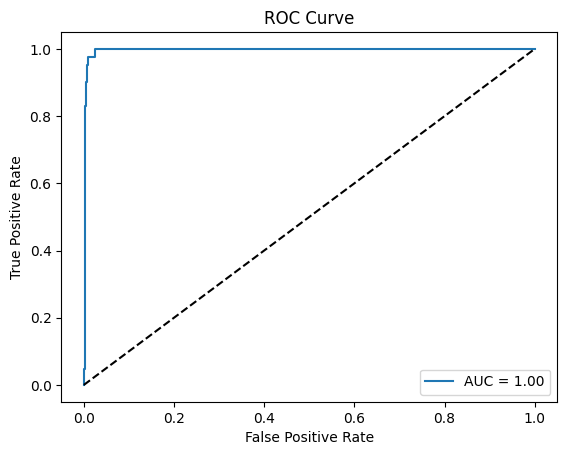

array([[516,   3],
       [  5,  36]])

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, criterion = "entropy", random_state = None,
                              max_depth=5, min_samples_leaf=5)


random_forest.fit(X_train, y_train)
y_probs = random_forest.predict_proba(X_test)[:, 1]
y_pred = random_forest.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
auc_score = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
confusion_matrix(y_test, y_pred)



### 6.4 Logistic Regression + Random Forest with less features

In [ ]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = processed_train_df.drop(columns='class')
y = processed_train_df['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'LogisticRegression': LogisticRegression(
        max_iter=10_000,
        solver='liblinear'
    )
}

features = X_train.columns.tolist()
results = []


r_max = 4
for r in range(1, r_max + 1):
    for combo in itertools.combinations(features, r):
        X_tr_sub = X_train[list(combo)]
        X_te_sub = X_test[list(combo)]
        for name, model in models.items():
            model.fit(X_tr_sub, y_train)
            preds = model.predict(X_te_sub)
            acc = accuracy_score(y_test, preds)
            results.append({
                'model': name,
                'features': combo,
                'accuracy': acc
            })


results_df = pd.DataFrame(results)

print(f"Evaluated {len(results_df)} model+subset runs (up to size {r_max}).\n")
print(results_df)

best20 = results_df.sort_values('accuracy', ascending=False).head(20)
print("\nTop 20 runs by accuracy:")
print(best20)


Evaluated 25900 model+subset runs (up to size 4).

                    model                                features  accuracy
0            RandomForest                                  (Age,)  0.917857
1      LogisticRegression                                  (Age,)  0.921429
2            RandomForest                                  (Sex,)  0.921429
3      LogisticRegression                                  (Sex,)  0.921429
4            RandomForest                         (On thyroxine,)  0.921429
...                   ...                                     ...       ...
25895  LogisticRegression  (TT4 measured, TT4, FTI measured, FTI)  0.930357
25896        RandomForest  (TT4 measured, T4u, FTI measured, FTI)  0.919643
25897  LogisticRegression  (TT4 measured, T4u, FTI measured, FTI)  0.932143
25898        RandomForest           (TT4, T4u, FTI measured, FTI)  0.917857
25899  LogisticRegression           (TT4, T4u, FTI measured, FTI)  0.933929

[25900 rows x 3 columns]

Top 20 run

too time consuming, illusory high results -> maxdepth, top 10 contributors to narrow down the pool

In [ ]:
rf_full = RandomForestClassifier(random_state=42, n_estimators=100)
rf_full.fit(X_train, y_train)
importances = pd.Series(rf_full.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(10).index.tolist()

print("Using feature pool:", top10)


models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, criterion = "entropy", random_state = None,
                              max_depth=5, min_samples_leaf=5),
    'LogisticRegression': LogisticRegression(max_iter=10_000, solver='liblinear')
}

results = []
for r in range(1, 5):
    for combo in itertools.combinations(top10, r):
        X_tr = X_train[list(combo)]
        X_te = X_test[list(combo)]
        for name, model in models.items():
            model.fit(X_tr, y_train)
            acc = accuracy_score(y_test, model.predict(X_te))
            results.append({
                'model': name,
                'features': combo,
                'accuracy': acc
            })

results_df = pd.DataFrame(results)
print(f"Total runs: {len(results_df)}")
print(results_df.sort_values('accuracy', ascending=False).head(20))

Using feature pool: ['TSH', 'FTI', 'TT4', 'On thyroxine', 'T3', 'Age', 'T4u', 'thyroid surgery', 'Sex', 'T3 measured']
Total runs: 770
            model                                   features  accuracy
366  RandomForest              (TSH, FTI, On thyroxine, Age)       1.0
368  RandomForest              (TSH, FTI, On thyroxine, T4u)       1.0
370  RandomForest  (TSH, FTI, On thyroxine, thyroid surgery)       1.0
372  RandomForest              (TSH, FTI, On thyroxine, Sex)       1.0
374  RandomForest      (TSH, FTI, On thyroxine, T3 measured)       1.0
406  RandomForest               (TSH, TT4, On thyroxine, T3)       1.0
408  RandomForest              (TSH, TT4, On thyroxine, Age)       1.0
410  RandomForest              (TSH, TT4, On thyroxine, T4u)       1.0
412  RandomForest  (TSH, TT4, On thyroxine, thyroid surgery)       1.0
414  RandomForest              (TSH, TT4, On thyroxine, Sex)       1.0
416  RandomForest      (TSH, TT4, On thyroxine, T3 measured)       1.0
144  RandomFo

Give-away indicators are omitted with only pure measurements left

In [ ]:
leakage_cols = [
    "On thyroxine",
    "query on thyroxine",
    "on antithyroid medication",
    "sick",
    "pregnant",
    "thyroid surgery",
    "I131 treatment",
    "query hypothyroid",
    "lithium",
    "goitre",
    "tumor",
    "psych",
    "TSH measured",
    "T3 measured",
    "TT4 measured",
    "FTI measured",
]

pure_features = ["Age", "Sex", "TSH", "T3", "T4u", "TT4", "FTI"]

X = processed_train_df[pure_features]
y = processed_train_df["class"]

X = pd.get_dummies(X, columns=["Sex"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, criterion = "entropy", random_state = None,
                              max_depth=5, min_samples_leaf=5),
    "LogisticRegression": LogisticRegression(
        max_iter=10_000,
        solver="liblinear"
    )
}

results = []
for r in range(1, 5):
    for combo in itertools.combinations(X_train.columns, r):
        X_tr = X_train[list(combo)]
        X_te = X_test[list(combo)]
        for name, model in models.items():
            model.fit(X_tr, y_train)
            acc = accuracy_score(y_test, model.predict(X_te))
            results.append({
                "model": name,
                "features": combo,
                "accuracy": acc
            })

results_df = pd.DataFrame(results)
print(f"Ran {len(results_df)} experiments (subsets size 1–4 of {pure_features}).\n")

print(results_df)

print("\nTop 20 by accuracy:")
print(results_df.sort_values("accuracy", ascending=False).head(20))


Ran 196 experiments (subsets size 1–4 of ['Age', 'Sex', 'TSH', 'T3', 'T4u', 'TT4', 'FTI']).

                  model                  features  accuracy
0          RandomForest                    (Age,)  0.919643
1    LogisticRegression                    (Age,)  0.921429
2          RandomForest                    (TSH,)  0.982143
3    LogisticRegression                    (TSH,)  0.950000
4          RandomForest                     (T3,)  0.921429
..                  ...                       ...       ...
191  LogisticRegression   (T3, T4u, FTI, Sex_1.0)  0.933929
192        RandomForest   (T3, TT4, FTI, Sex_1.0)  0.930357
193  LogisticRegression   (T3, TT4, FTI, Sex_1.0)  0.933929
194        RandomForest  (T4u, TT4, FTI, Sex_1.0)  0.930357
195  LogisticRegression  (T4u, TT4, FTI, Sex_1.0)  0.935714

[196 rows x 3 columns]

Top 20 by accuracy:
            model                  features  accuracy
102  RandomForest       (TSH, TT4, Sex_1.0)  0.985714
30   RandomForest                (

### 6.5 Analysis of Feature-Subset Results (1–4 Features)
- The main reason for the highet acc combo is bc it aligns with the actual medical practice
- **TSH** is the strongest individual predictor.  
- Adding **TT4** to TSH yields a large boost in accuracy.  
- Including the **Sex** dummy (`Sex_1.0`) gives RF its best score (0.986).   
- **Random Forest** consistently outperforms Logistic Regression in multi-feature subsets.



## 7.Submitting your Model

Once you believe to have found the best classifier, run your classifier on the test data and make a pickle file containing of your predictions contained a pandas dataframe.

This pandas dataframe will contain three columns for your binary classifier (or 5 columns for the multiclass classifier): the first column should be your model's "best guess" for each patient (either 0 or 1, negative or positive) and the last two columns should be the probability the patient would be classified as either a 0 or 1.

(see below for reference)

In [ ]:
#pickling example
import pickle
#predictions=pd.DataFrame({"guesses":[0,1,0,1],"prob_neg":[.75,.15,.63,.20],"prob_pos":[.25,.85,.27,.80]})
prediction_pickle_path = 'prediction_pickle.pkl'

pure_features = ["TSH", "TT4", "Sex", "FTI"]
random_forest.fit(processed_train_df[pure_features], processed_train_df["class"])

y_pos_probs = random_forest.predict_proba(processed_test_df[pure_features])[:, 1]
y_neg_probs = random_forest.predict_proba(processed_test_df[pure_features])[:, 0]
y_pred = random_forest.predict(processed_test_df[pure_features])
predictions = pd.DataFrame({"guesses": y_pred, "prob_neg": y_neg_probs, "prob_pos": y_pos_probs})

from google.colab import files
# Create an variable to pickle and open it in write mode
prediction_pickle = open(prediction_pickle_path, 'wb')
pickle.dump(predictions, prediction_pickle)
files.download(prediction_pickle_path)
prediction_pickle.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
prediction_unpickle = open(prediction_pickle_path, 'rb')

# load the unpickle object into a variable
predictions = pickle.load(prediction_unpickle)

print(predictions)

     guesses  prob_neg  prob_pos
0          0  0.999118  0.000882
1          0  0.998819  0.001181
2          0  0.979417  0.020583
3          0  0.999798  0.000202
4          0  0.999692  0.000308
..       ...       ...       ...
967        0  0.999118  0.000882
968        0  0.999118  0.000882
969        0  0.999118  0.000882
970        0  0.998218  0.001782
971        0  0.999248  0.000752

[972 rows x 3 columns]


We will compare your guesses with the true classifications to score your model using the AUC metric.

## 8.Presenting your Model

Finally, we would like you to be able to present your model to the class. Prepare a notebook with the following things:

* **Features Chosen:** a list of the features used in your model, and an explanation of how you chose them.
* **Type of Model:** an explanation of the model type, parameters used, and why.
* **Evaluation:** at least one plot showing an evaluation of your model against a validation set. You can use a confusion matrix, AUROC, or another metric of your choice.

Feel free to include one or two additional plots that describe your process and/or model if you think that would be helpful.

## 9.Moving to the Next Level

/tmp/ipython-input-96-828811249.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)


Accuracy: 0.9571428571428572


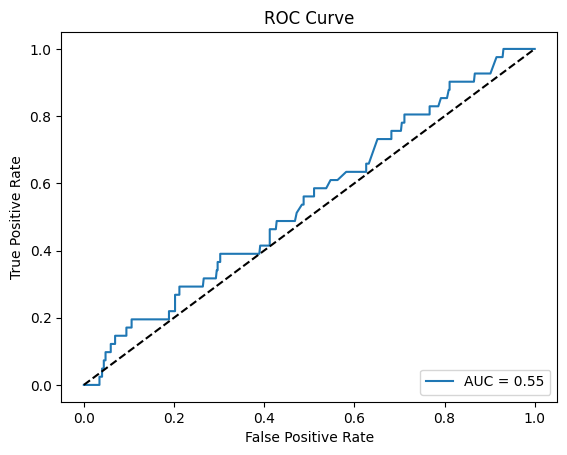

In [ ]:
def format_class_labels_multi(df):

  mapping = {
    **dict.fromkeys(["F","f"],0),
    **dict.fromkeys(["M","t"],1),
    "negative":0,
    **dict.fromkeys(["compensated hypothyroid"], 2),
    **dict.fromkeys(["primary hypothyroid"], 1),
    **dict.fromkeys(["secondary hypothyroid"], 3)
  }

  df.replace(mapping, inplace=True)
  df.replace("?", np.nan, inplace=True)

  for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    if df[col].dtype in [np.float64, np.int64]:
        median = df[col].median()
        df[col].fillna(median, inplace=True)
  return df


multi_train_df = format_class_labels_multi(train_df)

X_multi = multi_train_df.drop(columns='class')
y_multi = multi_train_df['class']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi,
    test_size=0.20,
    random_state=42,
)
random_forest = RandomForestClassifier(n_estimators=100, criterion = "entropy", random_state = None,
                              max_depth=5, min_samples_leaf=5)



random_forest.fit(X_train_multi, y_train_multi)
y_pred_multi = random_forest.predict(X_test_multi)
accuracy = accuracy_score(y_test_multi, y_pred_multi)
print("Accuracy:", accuracy)

y_probs = random_forest.predict_proba(X_test_multi)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
auc_score = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



For those that finish early, remember how we converted the class values into the binary of "negative" and "positive"? Now try tackling the multiclass classifier (predicting the different types of positive hypothyroid cases instead of simply negative or positive)!

The same rules apply!